In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from pathlib import Path
from tqdm import tqdm

In [7]:
audio_files = [f for f in Path('./data').glob('*.wav')]

In [8]:
example = str(audio_files[0])

In [9]:
# from fft part
def pad(lst):
    k = 0
    while 2**k < len(lst):
        k += 1
    return np.concatenate((lst, ([0] * (2 ** k - len(lst)))))
def FFT_vectorized(x):
    x = np.asarray(x, dtype=float)
    N_org=N = x.shape[0]

    if np.log2(N) % 1 > 0:
        x = pad(x)
        N = x.shape[0]
#         raise ValueError(f'{N} is not radix 2')

    N_min = min(N, 32)
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))
    
    
    while X.shape[0] < N:
        X_even = X[:, :X.shape[1] // 2]
        X_odd = X[:, X.shape[1] // 2:]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])
    return X.ravel()[:N_org]

### frequency domain + temporal information -> Spectrogram

- N: number of data in each section for FFT
- Fs: sample rate
- overlap_num: num of points of overlap between blocks.

In [10]:
def generate_spectrogram(data,N,fs,overlap_num = None):
    if overlap_num is None:
        overlap_num = N//2
    starts = np.arange(0,len(data),N-overlap_num,dtype=int)
    ffts = []
    
    for start in tqdm(starts):
        fft_window = np.abs(FFT_vectorized(data[start:start+N]))
        ffts.append(fft_window)
    print('done fft')
    spec = np.vstack(ffts[:-1])
    print(spec.shape)
    spec = np.log10(spec)
    
    return starts,spec

In [11]:
fs, data = wavfile.read(example)
print(data.shape)
data = data[:fs*60]
data.shape

(14796810, 2)


(2646000, 2)

In [12]:
signal = data.mean(axis=1)
starts,spec = generate_spectrogram(signal,fs,fs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 51.62it/s]

done fft
(119, 44100)


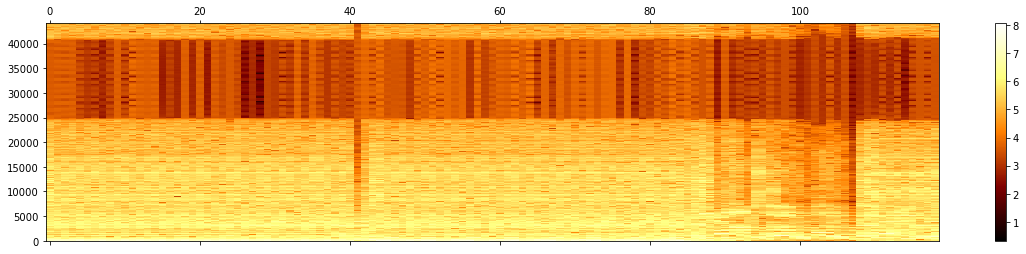

In [13]:
def plot_spectrogram(spec):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
    cax = ax.matshow(
        np.transpose(spec),
        interpolation="nearest",
        aspect="auto",
        cmap=plt.cm.afmhot,
        origin="lower",
    )
    fig.colorbar(cax)
# time windows 1s
plot_spectrogram(spec)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.16it/s]


done fft
(23, 220500)


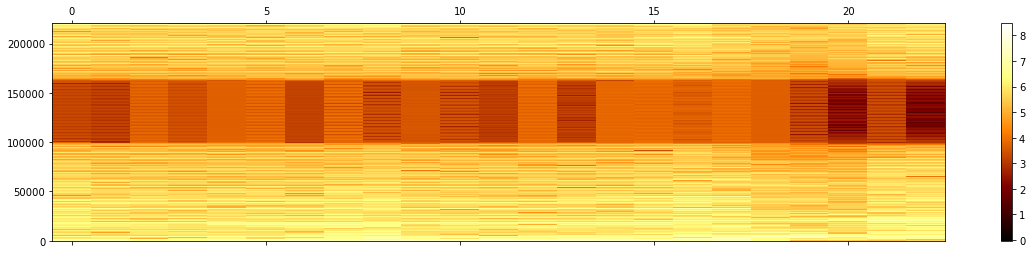

In [14]:
# time window 5s
starts,spec = generate_spectrogram(signal,fs*5,fs)
plot_spectrogram(spec)

### spectrogram with STFT
- FFT +
- multiply by half-cosine +
- pad data
- vectorized

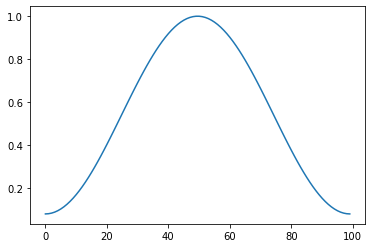

In [16]:
plt.plot(0.54 - 0.46 * np.cos(2 * np.pi * np.arange(100) / (100 - 1)))
plt.show()

In [17]:
def overlap(X, window_size, window_step):
    if window_size % 2 != 0:
        raise ValueError("Window size should be even!")
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in np.arange(nw):
        start = i * ss
        stop = start + ws
        out[i] = a[start:stop]

    return out

def stft(X, N=1024, overlap_num=256):
    X = overlap(X, N, overlap_num)

    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(N) / (N - 1)) # half-cosine
    X = X * win[np.newaxis]
    print(X.shape)
    ffts = []
    for line in tqdm(X):   
        line = FFT_vectorized(line)
#         line = np.abs(np.fft.fft(line)) for check
        ffts.append(line[:N//2])
    print('done fft')
    ffts = np.vstack(ffts[:-1])
    print(ffts.shape)
    return ffts

def generate_spectrogram_stft(data,N,overlap_num = None,thresh=5):
    if overlap_num is None:
        overlap_num = N//16
    spec = np.abs(stft(data, N, overlap_num))
    spec /= spec.max()
    spec = np.log10(spec)
    spec[spec < -thresh] = -thresh
    return spec

In [18]:
spec = generate_spectrogram_stft(signal.astype("float64"),2048)

(20656, 2048)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20656/20656 [00:08<00:00, 2434.79it/s]


done fft
(20655, 1024)


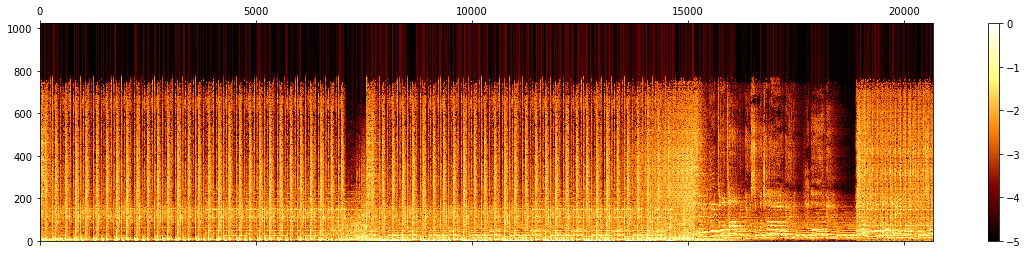

In [19]:
plot_spectrogram(spec)

### hz 2 mel
- mel_filter
- filter dot hz spectrogram

In [20]:
def hz2mel(hz):
    return 2595 * np.log10(1 + hz / 700.0)

def mel2hz(mel):
    return 700 * (10 ** (mel / 2595.0) - 1)

def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0):
    """Compute Mel filterbank. Filters are stored in the rows, Columns correspond
    to fft bins.
    nflit: number of fitlers
    nfft: fft size
    """
    highfreq = samplerate / 2
    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    #  from Hz to fft bin number
    bin = np.floor((nfft + 1) * mel2hz(melpoints) / samplerate)

    fbank = np.zeros([nfilt, nfft // 2])
    # bin
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    mel_filter = fbank.T / fbank.sum(axis=1)
    return mel_filter

def dot_mel_filter(spec, mel_filter):
    mel_spec = np.transpose(mel_filter).dot(np.transpose(spec))
    return mel_spec

In [21]:
mel_filter = get_filterbanks(nfft=2048,nfilt=64,samplerate=fs)

In [22]:
mel_filter.shape

(1024, 64)

Text(0.5, 1.0, 'mel Filter')

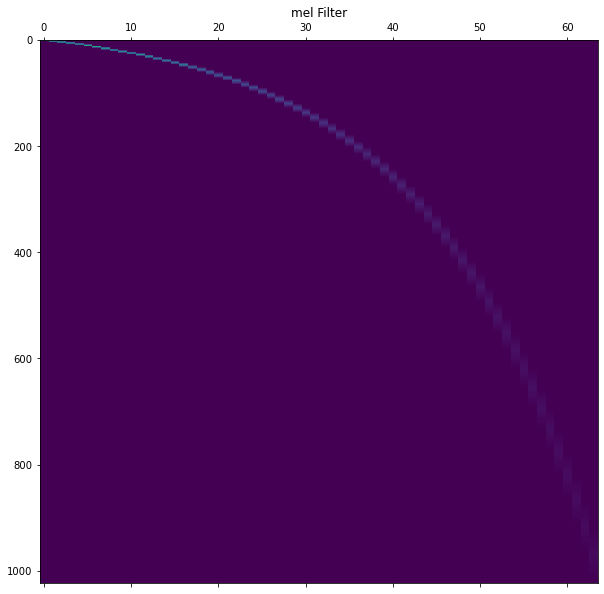

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.matshow(mel_filter, aspect="auto")
ax.set_title("mel Filter")

In [25]:
mel_spec = dot_mel_filter(spec, mel_filter)

In [214]:
mel_spec = dot_mel_filter(spec, mel_filter)

Text(0.5, 1.0, 'mel Spectrogram')

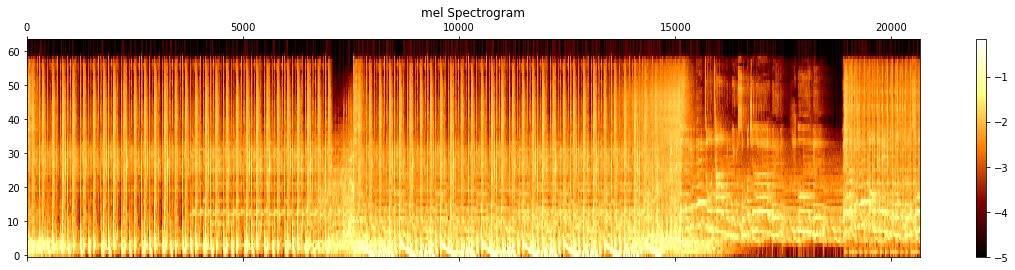

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(
    mel_spec.astype("float32"),
    interpolation="nearest",
    aspect="auto",
    cmap=plt.cm.afmhot,
    origin="lower",
)
fig.colorbar(cax)
plt.title("mel Spectrogram")

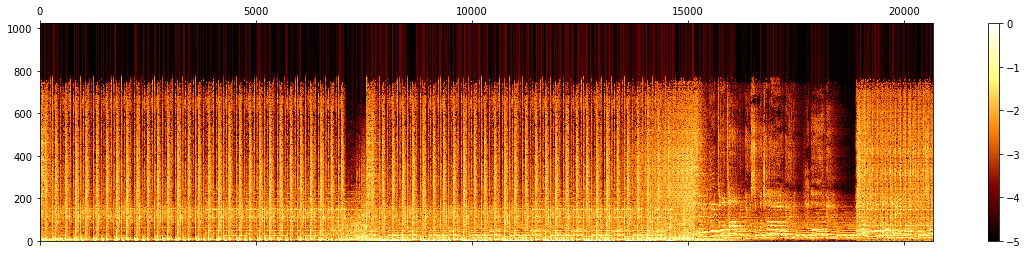

In [27]:
plot_spectrogram(spec)